In [56]:
import joblib
from sklearn.preprocessing import StandardScaler
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Load your dataset
df = pd.read_excel('/content/promethus_1000_examples.xlsx')

# Assume the dataset has the following structure based on previous features
X = df.drop(columns=['alert'])  # Exclude target variable
y = df['alert']  # Target variable for alert system monitoring

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler to a file

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_model = grid_search.best_estimator_

# Save the model
joblib.dump(best_model, 'xgboost_alert_model.pkl')  # Save the model to a file

# Evaluate the model
y_pred = best_model.predict(X_test)
print("Best Model Hyperparameters:", grid_search.best_params_)
print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Model Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Accuracy on Test Set: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       340
           1       0.85      0.88      0.87        60

    accuracy                           0.96       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.96      0.96      0.96       400



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:18:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


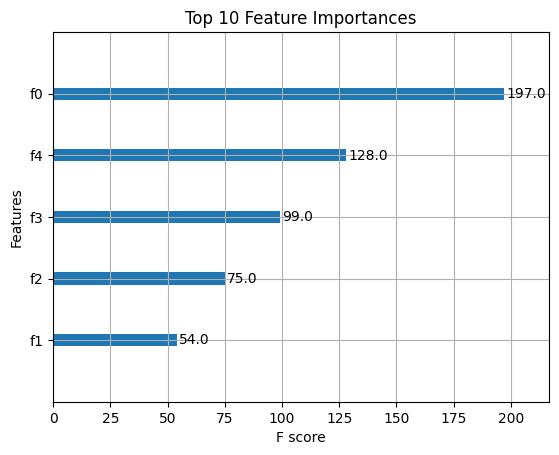

In [57]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()


In [58]:
import joblib

# Save the model to a file
joblib.dump(best_model, 'xgboost_alert_model.pkl')

['xgboost_alert_model.pkl']

In [54]:
!pip install flask xgboost pandas scikit-learn joblib


In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Initialize Flask app
app = Flask(__name__)

# Load the pre-trained XGBoost model and scaler
model = joblib.load('xgboost_alert_model.pkl')
scaler = joblib.load('scaler.pkl')  # Ensure you saved the scaler in your original code

# Define a prediction endpoint
@app.route('/metrics', methods=['POST'])
def predict():
    try:
        # Get the input data from the POST request
        data = request.get_json(force=True)

        # Convert data into DataFrame
        df = pd.DataFrame(data)

        # Scale the features using the same scaler
        X_scaled = scaler.transform(df)

        # Get predictions from the model
        predictions = model.predict(X_scaled)

        # Return the prediction as JSON
        response = {
            'predictions': predictions.tolist()  # Convert numpy array to list for JSON serialization
        }
        return jsonify(response), 200

    except Exception as e:
        return jsonify({'error': str(e)}), 400

# Run the Flask app
if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
